In [72]:

import heat_exchanger
from constants import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [73]:

# read GA3_previous_desgins.csv

df = pd.read_csv('GA3_previous_designs.csv')

# remove weird group C designs
df = df[~((df["year"] == 2022) & (df["group"] == "Group-C"))] # remove group C 2022
df = df[~((df["year"] == 2023) & (df["group"] == "Group-C"))] # remove group C 2023

df

,year,group,Tube Length,Tubes,Baffles,Pattern,Rotameter in1,Rotameter out1,DP_meas1,Tcold_in,...,DP_HX1,Qdot1,Flowrate2,DP_HX2,Qdot2,Qave,Effectiveness,Qcorr,Mass,Total Length
0,2022,Group-A,0.2360,14,12,TRIANGLE,24,25,0.252,19.4,...,0.305,9.97,0.483,0.122,10.78,10.38,0.171,11.53,1.081,0.350
1,2022,Group-B,0.2190,16,6,TRIANGLE,32,33,0.116,20.8,...,0.160,9.19,0.486,0.118,10.06,9.62,0.145,11.66,1.067,0.320
3,2022,Group-D,0.2590,"6,6",8,TRIANGLE,32,32,0.142,23.0,...,0.187,8.83,0.410,0.221,10.00,9.41,0.198,13.45,1.040,0.344
4,2022,Group-E,0.1520,"6,6,6,6",4,TRIANGLE,30,30,0.169,24.1,...,0.216,8.07,0.417,0.206,8.45,8.26,0.194,13.37,1.002,0.240
5,2022,Group-F,0.1720,"5,5,5,5","6,6",TRIANGLE,28,28,0.227,25.0,...,0.276,7.53,0.344,0.299,8.11,7.82,0.238,13.54,1.037,0.252
6,2022,Group-F,0.1720,"5,5,5,5","6,6",TRIANGLE,27,27,0.228,26.1,...,0.278,6.52,0.344,0.300,6.83,6.67,0.238,13.55,1.037,0.252
7,2022,Group-E,0.1520,"6,6,6,6",4,TRIANGLE,30,30,0.158,26.6,...,0.205,5.79,0.410,0.205,7.12,6.46,0.193,13.11,1.002,0.240
8,2022,Group-D,0.2590,"6,6",8,TRIANGLE,31,31,0.132,27.3,...,0.178,5.77,0.406,0.222,6.39,6.08,0.199,13.36,1.040,0.344
10,2022,Group-B,0.2190,16,6,TRIANGLE,34,35,0.111,28.5,...,0.153,5.47,0.479,0.120,5.55,5.51,0.150,11.92,1.067,0.320
11,2022,Group-A,0.2360,14,12,TRIANGLE,25,26,0.250,29.0,...,0.302,4.92,0.476,0.125,5.71,5.32,0.163,11.49,1.081,0.350


In [74]:

HX = heat_exchanger.build_heat_exchanger([2],[2], 0.31, Side.OPPOSITE, Pattern.SQUARE)
HX.set_conditions([20, 60])


In [75]:
mdot_colds = np.zeros(len(df))
mdot_hots = np.zeros(len(df))
Qdots = np.zeros(len(df))
effs = np.zeros(len(df))

for i, row in enumerate(df.iterrows()):
    
    tubes = str(row[1]["Tubes"]).split(",")
    tubes = [int(t) for t in tubes]
    baffles = str(row[1]["Baffles"]).split(",")
    baffles = [int(b) for b in baffles]
    length = float(row[1]["Tube Length"])

    pattern_str = row[1]["Pattern"]
    if pattern_str == "SQUARE":
        pattern = Pattern.SQUARE
    elif pattern_str == "TRIANGLE":
        pattern = Pattern.TRIANGLE
    
    HX = heat_exchanger.build_heat_exchanger(tubes, baffles, length, Side.OPPOSITE, pattern)
    HX.set_conditions([20, 60])
    HX.characteristic_year = row[1]["year"]

    result = HX.compute_effectiveness(method = "LMTD", optimiser="fsolve")

    if not result:
        continue

    Qdots[i] = HX.Qdot
    effs[i] = HX.effectiveness
    mdot_colds[i] = HX.mdot[0]
    mdot_hots[i] = HX.mdot[1]



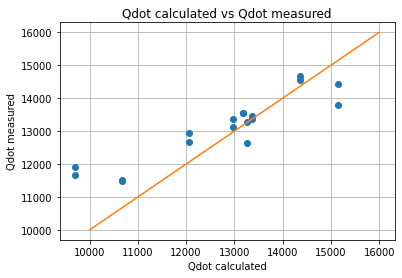

In [76]:
# plot Qdot calculated vs Qdot measured

lin = np.linspace(1e4, 1.6e4, 100)

plt.figure()
plt.plot(Qdots, 1e3*df["Qcorr"], 'o')
plt.plot(lin, lin)
plt.xlabel("Qdot calculated")
plt.ylabel("Qdot measured")
plt.title("Qdot calculated vs Qdot measured")
plt.grid()

# Doesnt look terrible!

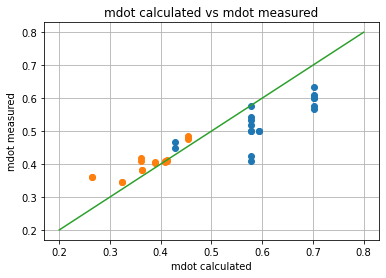

In [77]:
# plot mdot cold and mdot hot
lin = np.linspace(0.2, 0.8, 100)

plt.figure()
plt.plot(mdot_colds, df["Flowrate1"], 'o')
plt.plot(mdot_hots, df["Flowrate2"], 'o')
plt.plot(lin, lin)

plt.xlabel("mdot calculated")
plt.ylabel("mdot measured")
plt.title("mdot calculated vs mdot measured")
plt.grid()

# looks terrible need to fix


# sanity check measured mass flow and mass flow calculated from compressor characteristic data


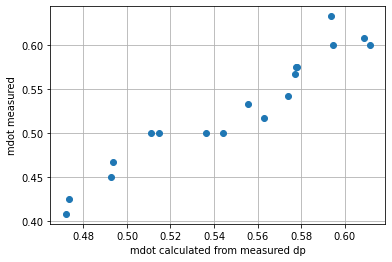

In [78]:
from heat_exchanger import cold_mass_flow_from_dp

mdot_cold_calc = np.zeros(len(df))

for i, row in enumerate(df.iterrows()):
    mdot_cold_calc[i] = cold_mass_flow_from_dp(row[1][" DP_meas1"] * 1e5, row[1]["year"])

plt.figure()
plt.plot(mdot_cold_calc, df["Flowrate1"], 'o')
plt.xlabel("mdot calculated from measured dp")
plt.ylabel("mdot measured")
plt.grid()

plt.show()


# OK so the compressor characteristics are followed